# Discrete Vicsek model in 2d

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

In [2]:
def get_neighbors(positions, idx, neighbor_dist, kd_tree: KDTree):
    x, y = positions[idx]
    indices = kd_tree.query_ball_point((x, y), neighbor_dist)
    return np.array(indices) % len(positions)

def get_average_velocities(velocities, indices, eta, v_0):
    new_velocity = np.sum(velocities[indices], axis=0)
    angle = np.arctan2(new_velocity[1], new_velocity[0])
    angle = angle + np.random.random() * eta - eta / 2
    return np.array([np.cos(angle), np.sin(angle)]) * v_0

def get_PBC_points(points, L):
    relative_delta_list = [[0, 0], [0, L], [L, 0], [0, -L], [-L, 0], [L, L], [L, -L], [-L, L], [-L, -L]]
    return np.concatenate([points + np.array([_]) for _ in relative_delta_list])

In [3]:
def simulate(num_particles, eta, v_0, neighbor_dist, L, num_iter, num_repeat):
    positions = np.random.random(size=(num_particles, 2)) * L
    velocities = np.random.random(size=num_particles) * 2 * np.pi
    velocities = np.array([np.cos(velocities), np.sin(velocities)]).T * v_0
    history_postions = []
    history_velocities = []
    for iter in range(num_iter):
        # 更新速度
        new_vel = np.zeros_like(velocities)
        kd_tree = KDTree(get_PBC_points(positions, L))
        for idx in range(len(positions)):
            new_vel[idx] = get_average_velocities(velocities, get_neighbors(positions, idx, neighbor_dist, kd_tree), eta, v_0)
        # 更新位置
        positions = (positions + new_vel) % np.array([L, L])
        velocities = new_vel
        history_postions.append(positions.copy())
        history_velocities.append(velocities.copy())
        # if iter % 100 == 0:
            # print(iter)
    np.save('./SimulationData/positions(np%d,eta%.2f,v0%.2f,nd%.2f,L%.2f,ni%d,nr%d).npy' % (num_particles, eta, v_0, neighbor_dist, L, num_iter, num_repeat), history_postions)
    np.save('./SimulationData/velocities(np%d,eta%.2f,v0%.2f,nd%.2f,L%.2f,ni%d,nr%d).npy' % (num_particles, eta, v_0, neighbor_dist, L, num_iter, num_repeat), history_velocities)

In [43]:
import itertools
num_particles_s = [400, 4000, 10000]
eta_s = np.arange(4.5, 5.1, 0.1)
v_0_s = [0.03]
neighbor_dist_s = [1.0]
L_s = [np.sqrt(n_p / 4) for n_p in num_particles_s]
num_iter_s = [1000]
num_repeat_s = list(range(5))

for combination in itertools.product(num_particles_s, eta_s, v_0_s, neighbor_dist_s, L_s, num_iter_s, num_repeat_s):
    simulate(*combination)
    print(combination)
  

(400, 4.5, 0.03, 1.0, 10.0, 1000, 0)
(400, 4.5, 0.03, 1.0, 10.0, 1000, 1)


KeyboardInterrupt: 

In [46]:
history_postions = np.load('./SimulationData/positions(np400,eta4.50,v00.03,nd1.00,L10.00,ni1000,nr1).npy')
history_velocities = np.load('./SimulationData/velocities(np400,eta4.50,v00.03,nd1.00,L10.00,ni1000,nr1).npy')
num_particles = 400
eta = 3.5
v_0 = 0.03
neighbor_dist = 1.0
L = 10
num_iter = 1000

In [47]:
np.mean(np.sqrt(np.sum(np.mean(history_velocities[500:], axis=1) * np.mean(history_velocities[500:], axis=1), axis=1))) / .03

0.10101269154807634

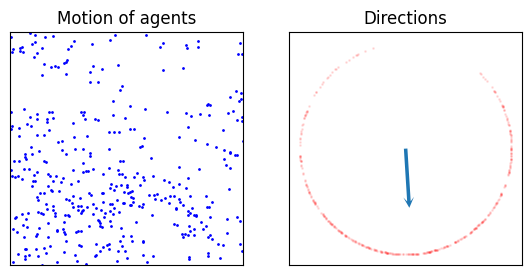

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 假设点位数据，这里生成一些随机数据作为示例
x_data = history_postions[0].T[0]
y_data = history_postions[0].T[1]


mosaic = """
    AB
    """
fig, axs = plt.subplot_mosaic(mosaic)
plt.subplots_adjust(left=0.1,  # 左边界留白
                    right=0.9,  # 右边界留白
                    bottom=0.1,  # 底部界留白
                    top=0.9,  # 顶部界留白
                    wspace=0.2,  # 子图之间的宽度间距
                    hspace=0.2)

line, = axs['A'].plot([], [], 'bo', markersize=1)  # 'bo'表示蓝色圆点
angle_vel, = axs['B'].plot([], [], 'ro', alpha=0.1, markersize=1)
average_vel = axs['B'].arrow(0, 0, 0, 0, head_width=0.1 * v_0, head_length=0.1 * v_0, overhang=0.4, linewidth = 0.1 * v_0)

# 初始化函数，用于FuncAnimation
def init():
    axs['A'].set_title('Motion of agents')
    axs['A'].set_xlim(0, L)
    axs['A'].set_ylim(0, L)
    axs['A'].axis('scaled')
    axs['A'].set_xticks([])
    axs['A'].set_yticks([])
    axs['A'].set_xticklabels([])
    axs['A'].set_yticklabels([])

    axs['B'].set_title('Directions')
    axs['B'].axis('scaled')
    axs['B'].set_xlim(-1.1 * v_0, 1.1 * v_0)
    axs['B'].set_ylim(-1.1 * v_0, 1.1 * v_0)
    axs['B'].set_xticks([])
    axs['B'].set_yticks([])
    axs['B'].set_xticklabels([])
    axs['B'].set_yticklabels([])

    return line,

# 更新函数，每一帧调用一次
def update(frame):
    line.set_data(history_postions[frame+1].T[0], history_postions[frame+1].T[1])
    angle_vel.set_data(history_velocities[frame+1].T[0], history_velocities[frame+1].T[1])
    average_vel.set_data(x=0, y=0, dx=np.mean(history_velocities[frame+1].T[0]), dy = np.mean(history_velocities[frame+1].T[1]))
    return line, angle_vel,

# 创建动画
ani = FuncAnimation(fig, update, frames=range(num_iter-1), init_func=init, blit=True)

# 显示动画
ani.save('animation(x).mp4', fps=50, dpi=300)


In [39]:
np.mean(np.sqrt(np.sum(np.mean(history_velocities[500:], axis=1) * np.mean(history_velocities[500:], axis=1), axis=1)))

0.01106082850892962

In [23]:
history_velocities

array([[[-0.01305166, -0.02701211],
        [-0.01084775,  0.0279701 ],
        [-0.022474  ,  0.01987258],
        ...,
        [ 0.02050658,  0.02189704],
        [ 0.02910082, -0.00728987],
        [-0.00594071, -0.02940592]],

       [[-0.02846353, -0.00947775],
        [-0.01437128,  0.02633375],
        [-0.00097101, -0.02998428],
        ...,
        [ 0.01509025,  0.02592845],
        [ 0.01431506, -0.02636435],
        [ 0.02976915,  0.00371452]],

       [[-0.01006513, -0.02826116],
        [ 0.02865672, -0.00887652],
        [-0.00493403, -0.02959147],
        ...,
        [-0.00563599, -0.02946584],
        [ 0.02997131,  0.0013118 ],
        [ 0.02412534, -0.01783166]],

       ...,

       [[ 0.00146862, -0.02996403],
        [-0.00766963, -0.02900305],
        [-0.013663  , -0.0267081 ],
        ...,
        [ 0.02579652,  0.01531469],
        [-0.00497351, -0.02958486],
        [-0.0013596 , -0.02996918]],

       [[-0.00837422, -0.02880751],
        [-0.00977559, -0.02